In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.12.0


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("Demand_History.csv")

In [3]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

In [4]:
import matplotlib.pyplot as plt 

In [5]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

In [6]:
import json
import urllib
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal


class ChickenpoxDatasetLoader(object):
    """A dataset of county level chicken pox cases in Hungary between 2004
    and 2014. We made it public during the development of PyTorch Geometric
    Temporal. The underlying graph is static - vertices are counties and
    edges are neighbourhoods. Vertex features are lagged weekly counts of the
    chickenpox cases (we included 4 lags). The target is the weekly number of
    cases for the upcoming week (signed integers). Our dataset consist of more
    than 500 snapshots (weeks).
    """

    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        url = "https://raw.githubusercontent.com/benedekrozemberczki/pytorch_geometric_temporal/master/dataset/chickenpox.json"
        self._dataset = json.loads(urllib.request.urlopen(url).read())

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
#         stacked_target = np.array(self._dataset["FX"])
#         self.features = [
#             stacked_target[i : i + self.lags, :].T
#             for i in range(stacked_target.shape[0] - self.lags)
#         ]
#         self.targets = [
#             stacked_target[i + self.lags, :].T
#             for i in range(stacked_target.shape[0] - self.lags)
#         ]
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target
    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [7]:
df = pd.read_csv("Demand_History.csv")

In [8]:
edges = []
for a in df['demand_point_index']:
    if(a-64>=0):
        edges.append([a,a-64])
    if(a-1>=0):
        edges.append([a,a-1])
    if(a+1<4096):
        edges.append([a,a+1])
    if(a+64<4096):
        edges.append([a,a+64])


In [9]:
df.drop(['x_coordinate', 'y_coordinate'], axis=1)

,demand_point_index,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,1,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,2,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,3,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,4,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563
...,...,...,...,...,...,...,...,...,...,...
4091,4091,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193
4092,4092,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450
4093,4093,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519
4094,4094,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574


In [10]:
node_ids = {}
for i in range(len(df)):
    node_ids[str(df.loc[i,'x_coordinate'])+", "+str(df.loc[i,'y_coordinate'])] = i

In [11]:
FX = []
for j in range(len(df.drop(['x_coordinate', 'y_coordinate','demand_point_index'], axis=1).columns)):
    t = []
    for i in range(len(df)):
        t.append(df.drop(['x_coordinate', 'y_coordinate','demand_point_index'], axis=1).iloc[i,j])
    FX.append(t)

In [12]:
df_final = {
    "edges" : edges,
    "node_ids" : node_ids,
    "FX" : FX
}

In [13]:
class ShellAI(object):


    def __init__(self):
        self._dataset = df_final

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 3) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [14]:
loader = ShellAI()

In [15]:
data = loader.get_dataset(lags=3)

In [16]:
next(iter(data))

Data(x=[4096, 3], edge_index=[2, 16254], edge_attr=[16254], y=[4096])

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods=1)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [18]:
device = torch.device('cuda') # cuda

# Create model and optimizers
model = TemporalGNN(node_features=1, periods=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
model.train()

print("Running training...")
for epoch in range(2000): 
    loss = 0
    step = 0
    for snapshot in data :
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x.reshape(4096,1,3), snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 5487.7925
Epoch 1 train MSE: 5443.5381
Epoch 2 train MSE: 5419.6538
Epoch 3 train MSE: 5391.7642
Epoch 4 train MSE: 5373.7412
Epoch 5 train MSE: 5352.5259
Epoch 6 train MSE: 5335.5703
Epoch 7 train MSE: 5320.1196
Epoch 8 train MSE: 5305.1943
Epoch 9 train MSE: 5290.4609
Epoch 10 train MSE: 5275.7925
Epoch 11 train MSE: 5261.1382
Epoch 12 train MSE: 5246.4800
Epoch 13 train MSE: 5231.8184
Epoch 14 train MSE: 5217.1592
Epoch 15 train MSE: 5202.5156
Epoch 16 train MSE: 5187.9004
Epoch 17 train MSE: 5173.3306
Epoch 18 train MSE: 5158.8193
Epoch 19 train MSE: 5144.3818
Epoch 20 train MSE: 5130.0288
Epoch 21 train MSE: 5115.7710
Epoch 22 train MSE: 5101.6162
Epoch 23 train MSE: 5087.5718
Epoch 24 train MSE: 5073.6396
Epoch 25 train MSE: 5059.8252
Epoch 26 train MSE: 5046.1260
Epoch 27 train MSE: 5032.5430
Epoch 28 train MSE: 5019.0767
Epoch 29 train MSE: 5005.7222
Epoch 30 train MSE: 4992.4790
Epoch 31 train MSE: 4979.3438
Epoch 32 train MSE: 4966.3135


Epoch 268 train MSE: 3382.7329
Epoch 269 train MSE: 3380.0540
Epoch 270 train MSE: 3377.3958
Epoch 271 train MSE: 3374.7590
Epoch 272 train MSE: 3372.1433
Epoch 273 train MSE: 3369.5481
Epoch 274 train MSE: 3366.9739
Epoch 275 train MSE: 3364.4204
Epoch 276 train MSE: 3361.8862
Epoch 277 train MSE: 3359.3735
Epoch 278 train MSE: 3356.8811
Epoch 279 train MSE: 3354.4080
Epoch 280 train MSE: 3351.9548
Epoch 281 train MSE: 3349.5220
Epoch 282 train MSE: 3347.1089
Epoch 283 train MSE: 3344.7151
Epoch 284 train MSE: 3342.3406
Epoch 285 train MSE: 3339.9856
Epoch 286 train MSE: 3337.6499
Epoch 287 train MSE: 3335.3333
Epoch 288 train MSE: 3333.0354
Epoch 289 train MSE: 3330.7563
Epoch 290 train MSE: 3328.4958
Epoch 291 train MSE: 3326.2546
Epoch 292 train MSE: 3324.0315
Epoch 293 train MSE: 3321.8267
Epoch 294 train MSE: 3319.6396
Epoch 295 train MSE: 3317.4714
Epoch 296 train MSE: 3315.3213
Epoch 297 train MSE: 3313.1882
Epoch 298 train MSE: 3311.0735
Epoch 299 train MSE: 3308.9768
Epoch 30

Epoch 533 train MSE: 3028.9856
Epoch 534 train MSE: 3028.2263
Epoch 535 train MSE: 3027.4683
Epoch 536 train MSE: 3026.7122
Epoch 537 train MSE: 3025.9583
Epoch 538 train MSE: 3025.2073
Epoch 539 train MSE: 3024.4592
Epoch 540 train MSE: 3023.7146
Epoch 541 train MSE: 3022.9744
Epoch 542 train MSE: 3022.2390
Epoch 543 train MSE: 3021.5081
Epoch 544 train MSE: 3020.7820
Epoch 545 train MSE: 3020.0610
Epoch 546 train MSE: 3019.3455
Epoch 547 train MSE: 3018.6357
Epoch 548 train MSE: 3017.9314
Epoch 549 train MSE: 3017.2332
Epoch 550 train MSE: 3016.5405
Epoch 551 train MSE: 3015.8538
Epoch 552 train MSE: 3015.1726
Epoch 553 train MSE: 3014.4973
Epoch 554 train MSE: 3013.8276
Epoch 555 train MSE: 3013.1633
Epoch 556 train MSE: 3012.5046
Epoch 557 train MSE: 3011.8511
Epoch 558 train MSE: 3011.2034
Epoch 559 train MSE: 3010.5603
Epoch 560 train MSE: 3009.9231
Epoch 561 train MSE: 3009.2903
Epoch 562 train MSE: 3008.6631
Epoch 563 train MSE: 3008.0403
Epoch 564 train MSE: 3007.4224
Epoch 56

Epoch 798 train MSE: 2925.3494
Epoch 799 train MSE: 2925.1677
Epoch 800 train MSE: 2924.9873
Epoch 801 train MSE: 2924.8081
Epoch 802 train MSE: 2924.6301
Epoch 803 train MSE: 2924.4539
Epoch 804 train MSE: 2924.2786
Epoch 805 train MSE: 2924.1045
Epoch 806 train MSE: 2923.9321
Epoch 807 train MSE: 2923.7605
Epoch 808 train MSE: 2923.5903
Epoch 809 train MSE: 2923.4214
Epoch 810 train MSE: 2923.2534
Epoch 811 train MSE: 2923.0872
Epoch 812 train MSE: 2922.9221
Epoch 813 train MSE: 2922.7581
Epoch 814 train MSE: 2922.5950
Epoch 815 train MSE: 2922.4333
Epoch 816 train MSE: 2922.2729
Epoch 817 train MSE: 2922.1138
Epoch 818 train MSE: 2921.9558
Epoch 819 train MSE: 2921.7986
Epoch 820 train MSE: 2921.6433
Epoch 821 train MSE: 2921.4888
Epoch 822 train MSE: 2921.3352
Epoch 823 train MSE: 2921.1826
Epoch 824 train MSE: 2921.0315
Epoch 825 train MSE: 2920.8816
Epoch 826 train MSE: 2920.7327
Epoch 827 train MSE: 2920.5847
Epoch 828 train MSE: 2920.4377
Epoch 829 train MSE: 2920.2917
Epoch 83

Epoch 1061 train MSE: 2898.2122
Epoch 1062 train MSE: 2898.1401
Epoch 1063 train MSE: 2898.0615
Epoch 1064 train MSE: 2897.9871
Epoch 1065 train MSE: 2897.9175
Epoch 1066 train MSE: 2897.8416
Epoch 1067 train MSE: 2897.7659
Epoch 1068 train MSE: 2897.6965
Epoch 1069 train MSE: 2897.6248
Epoch 1070 train MSE: 2897.5503
Epoch 1071 train MSE: 2897.4812
Epoch 1072 train MSE: 2897.4136
Epoch 1073 train MSE: 2897.3423
Epoch 1074 train MSE: 2897.2725
Epoch 1075 train MSE: 2897.2048
Epoch 1076 train MSE: 2897.1365
Epoch 1077 train MSE: 2897.0686
Epoch 1078 train MSE: 2897.0027
Epoch 1079 train MSE: 2896.9360
Epoch 1080 train MSE: 2896.8689
Epoch 1081 train MSE: 2896.8042
Epoch 1082 train MSE: 2896.7400
Epoch 1083 train MSE: 2896.6750
Epoch 1084 train MSE: 2896.6116
Epoch 1085 train MSE: 2896.5483
Epoch 1086 train MSE: 2896.4851
Epoch 1087 train MSE: 2896.4229
Epoch 1088 train MSE: 2896.3611
Epoch 1089 train MSE: 2896.2998
Epoch 1090 train MSE: 2896.2390
Epoch 1091 train MSE: 2896.1790
Epoch 10

Epoch 1318 train MSE: 2889.8650
Epoch 1319 train MSE: 2889.8108
Epoch 1320 train MSE: 2889.8687
Epoch 1321 train MSE: 2889.9475
Epoch 1322 train MSE: 2889.9392
Epoch 1323 train MSE: 2889.8823
Epoch 1324 train MSE: 2889.9097
Epoch 1325 train MSE: 2889.9114
Epoch 1326 train MSE: 2889.8423
Epoch 1327 train MSE: 2889.7976
Epoch 1328 train MSE: 2889.8110
Epoch 1329 train MSE: 2889.7720
Epoch 1330 train MSE: 2889.7144
Epoch 1331 train MSE: 2889.7339
Epoch 1332 train MSE: 2889.7446
Epoch 1333 train MSE: 2889.6550
Epoch 1334 train MSE: 2889.6001
Epoch 1335 train MSE: 2889.6233
Epoch 1336 train MSE: 2889.6128
Epoch 1337 train MSE: 2889.5618
Epoch 1338 train MSE: 2889.5396
Epoch 1339 train MSE: 2889.5369
Epoch 1340 train MSE: 2889.5122
Epoch 1341 train MSE: 2889.4858
Epoch 1342 train MSE: 2889.4753
Epoch 1343 train MSE: 2889.4573
Epoch 1344 train MSE: 2889.4138
Epoch 1345 train MSE: 2889.3728
Epoch 1346 train MSE: 2889.3489
Epoch 1347 train MSE: 2889.3213
Epoch 1348 train MSE: 2889.3003
Epoch 13

Epoch 1575 train MSE: 2886.6785
Epoch 1576 train MSE: 2886.6685
Epoch 1577 train MSE: 2886.6604
Epoch 1578 train MSE: 2886.6499
Epoch 1579 train MSE: 2886.6414
Epoch 1580 train MSE: 2886.6333
Epoch 1581 train MSE: 2886.6262
Epoch 1582 train MSE: 2886.6196
Epoch 1583 train MSE: 2886.6135
Epoch 1584 train MSE: 2886.6079
Epoch 1585 train MSE: 2886.6025
Epoch 1586 train MSE: 2886.5974
Epoch 1587 train MSE: 2886.5928
Epoch 1588 train MSE: 2886.5894
Epoch 1589 train MSE: 2886.5845
Epoch 1590 train MSE: 2886.5828
Epoch 1591 train MSE: 2886.5774
Epoch 1592 train MSE: 2886.5767
Epoch 1593 train MSE: 2886.5679
Epoch 1594 train MSE: 2886.5652
Epoch 1595 train MSE: 2886.5532
Epoch 1596 train MSE: 2886.5459
Epoch 1597 train MSE: 2886.5342
Epoch 1598 train MSE: 2886.5251
Epoch 1599 train MSE: 2886.5159
Epoch 1600 train MSE: 2886.5081
Epoch 1601 train MSE: 2886.5010
Epoch 1602 train MSE: 2886.4949
Epoch 1603 train MSE: 2886.4890
Epoch 1604 train MSE: 2886.4834
Epoch 1605 train MSE: 2886.4783
Epoch 16

Epoch 1832 train MSE: 2888.8364
Epoch 1833 train MSE: 2888.8025
Epoch 1834 train MSE: 2888.7690
Epoch 1835 train MSE: 2888.7346
Epoch 1836 train MSE: 2888.7000
Epoch 1837 train MSE: 2888.6653
Epoch 1838 train MSE: 2888.6321
Epoch 1839 train MSE: 2888.6001
Epoch 1840 train MSE: 2888.5681
Epoch 1841 train MSE: 2888.5364
Epoch 1842 train MSE: 2888.5054
Epoch 1843 train MSE: 2888.4753
Epoch 1844 train MSE: 2888.4456
Epoch 1845 train MSE: 2888.4158
Epoch 1846 train MSE: 2888.3862
Epoch 1847 train MSE: 2888.3569
Epoch 1848 train MSE: 2888.3284
Epoch 1849 train MSE: 2888.2998
Epoch 1850 train MSE: 2888.2720
Epoch 1851 train MSE: 2888.2439
Epoch 1852 train MSE: 2888.2166
Epoch 1853 train MSE: 2888.1899
Epoch 1854 train MSE: 2888.1636
Epoch 1855 train MSE: 2888.1375
Epoch 1856 train MSE: 2888.1116
Epoch 1857 train MSE: 2888.0862
Epoch 1858 train MSE: 2888.0610
Epoch 1859 train MSE: 2888.0361
Epoch 1860 train MSE: 2888.0115
Epoch 1861 train MSE: 2887.9873
Epoch 1862 train MSE: 2887.9634
Epoch 18

In [19]:
T = []
for j in range(len(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2010','2011','2012','2013','2014','2015'], axis=1).columns)):
    t = []
    for i in range(len(df)):
        t.append(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2010','2011','2012','2013','2014','2015'], axis=1).iloc[i,j])
    T.append(t)
d = list(np.zeros(4096))
T.append(d)


In [20]:
df_test = {
    "edges" : edges,
    "node_ids" : node_ids,
    "FX" : T
}

In [21]:
class TestData(object):


    def __init__(self):
        self._dataset = df_test

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 3) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [22]:
model.eval()

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [23]:
test_dataset = TestData().get_dataset(lags=3)

In [24]:
next(iter(test_dataset))

Data(x=[4096, 3], edge_index=[2, 16254], edge_attr=[16254], y=[4096])

In [25]:
device = torch.device('cuda') # cuda
loss = 0
step = 0

# Store for analysis
demand_2019 = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x.reshape(4096,1,3), snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    demand_2019.append(y_hat)
    step += 1
    print(step)

loss = loss / (step+1)
print("Test MSE: {:.4f}".format(loss))

1
Test MSE: 2279.6787


In [26]:
print(demand_2019)

[tensor([[54.1763],
        [55.2737],
        [55.2916],
        ...,
        [41.0003],
        [41.0422],
        [41.0438]], device='cuda:0', grad_fn=<AddmmBackward0>)]


In [29]:
demand_2019 = np.array(demand_2019[0].detach().cpu())

In [30]:
demand_2019 = demand_2019.reshape(4096,)

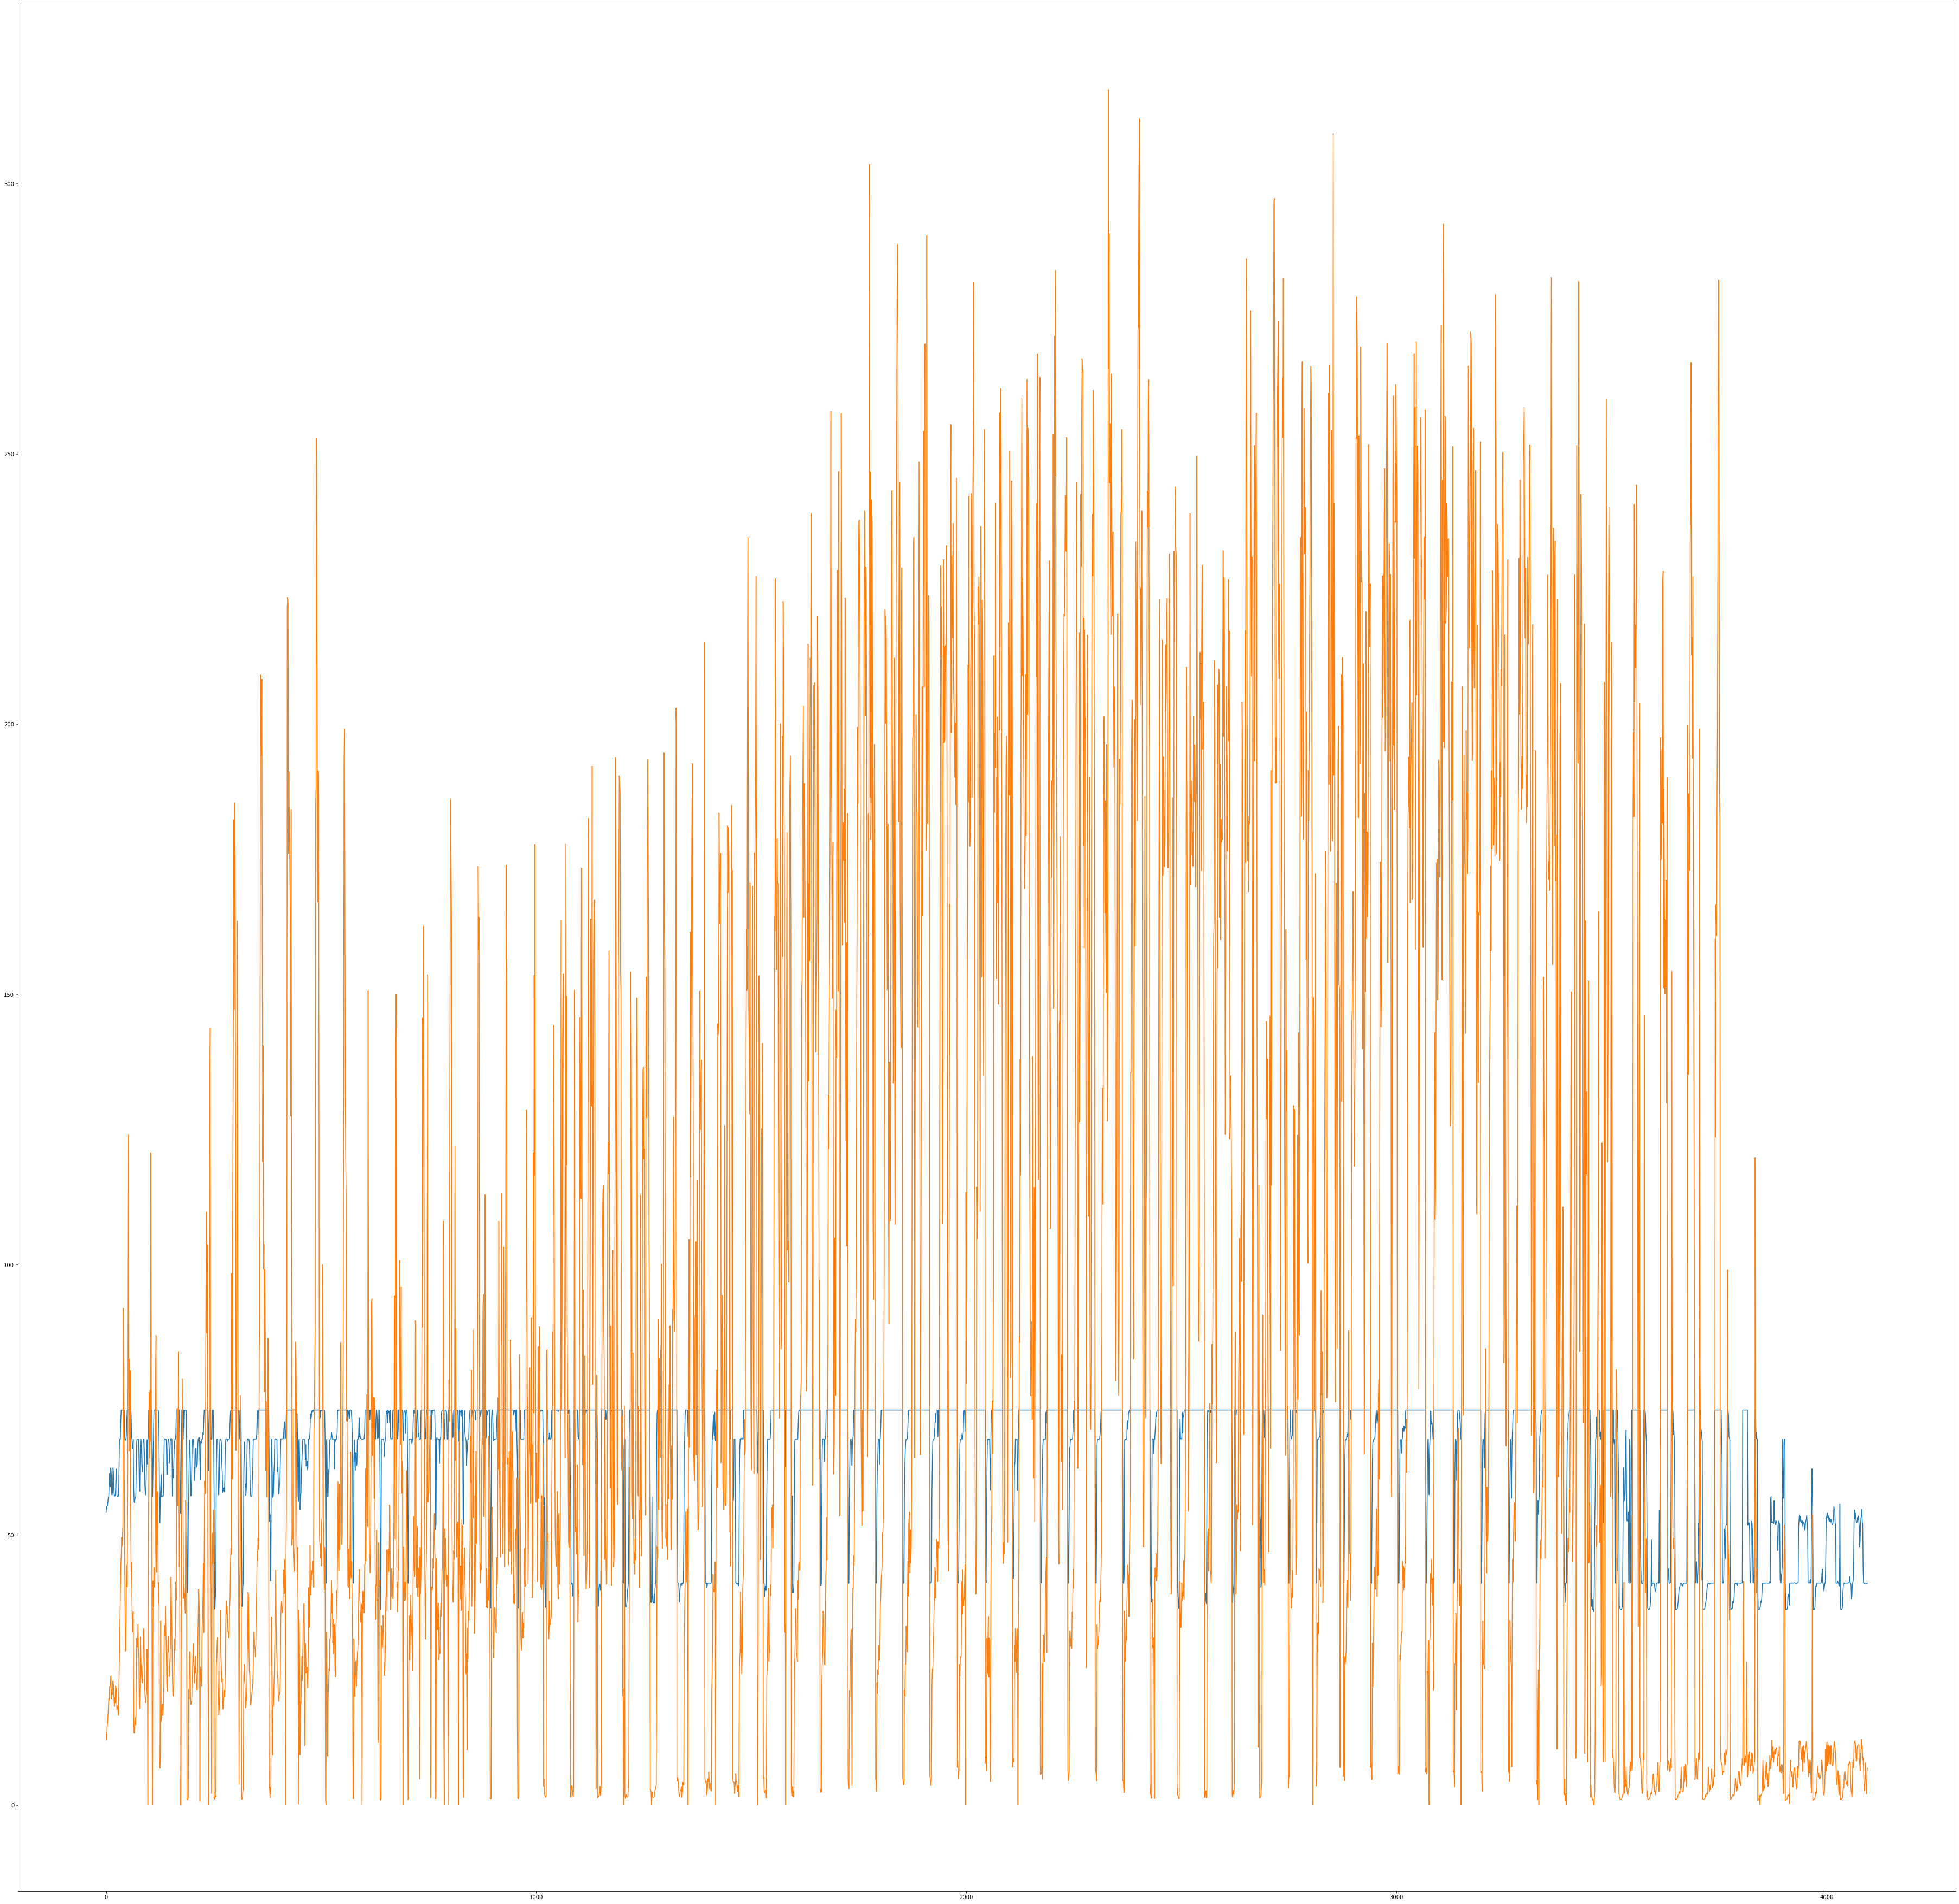

In [35]:
fig = plt.figure(figsize=(64,64))
plt.plot(range(0,4096),demand_2019)
plt.plot(range(0,4096),df.loc[:,'2018'])
# plt.scatter(range(0,32),df.iloc[:32,0])
plt.show()

In [37]:
abs(df.loc[:,'2018']-pd.DataFrame(demand_2019)).sum()

0       219037.020097
1            0.000000
2            0.000000
3            0.000000
4            0.000000
            ...      
4091         0.000000
4092         0.000000
4093         0.000000
4094         0.000000
4095         0.000000
Length: 4096, dtype: float64

In [31]:
T = []
for j in range(len(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2010','2011','2012','2013','2014','2015','2016'], axis=1).columns)):
    t = []
    for i in range(len(df)):
        t.append(df.drop(['x_coordinate', 'y_coordinate','demand_point_index','2010','2011','2012','2013','2014','2015','2016'], axis=1).iloc[i,j])
    T.append(t)
T.append(demand_2019)
d = list(np.zeros(4096))
T.append(d)

In [32]:
df_test = {
    "edges" : edges,
    "node_ids" : node_ids,
    "FX" : T
}

In [33]:
test_dataset = TestData().get_dataset(lags=3)

In [34]:
device = torch.device('cuda') # cuda
loss = 0
step = 0

# Store for analysis
demand_2020 = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x.reshape(4096,1,3), snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    demand_2020.append(y_hat)
    step += 1
    print(step)

loss = loss / (step+1)
print("Test MSE: {:.4f}".format(loss))

1
Test MSE: 2362.9143


In [43]:
demand_2020 = np.array(demand_2020[0].detach().cpu())
demand_2020 = demand_2020.reshape(4096,)

AttributeError: 'numpy.float32' object has no attribute 'detach'

In [44]:
dx = df
dx['2019'] = demand_2019
dx['2020'] = demand_2020

In [45]:
dx.head()

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,54.176315,56.992561
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,55.273689,57.075462
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,55.291611,57.088287
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,55.404137,57.206757
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,56.079346,58.839165


In [48]:
dx.to_csv("Demand_History_predicted.csv",index = False)